In [1]:

from occupancy.datasets.nuscenes import NuscenesDataset
from nuscenes.nuscenes import NuScenes
nusc = NuscenesDataset(
    version='v1.0-trainval',
    data_dir='/mnt/f/datasets/nuscenes/',
    verbose=True)


In [2]:
data =nusc[165]

In [3]:
voxel1 = data.lidar_top.voxel
voxel2 = data.lidar_top._pointcloud_to_voxelgrid(data.lidar_top.location[0], data.lidar_top.attribute[0])

In [4]:
import torch

In [5]:
import matplotlib.pyplot as plt


voxel1 = voxel1.float()[0, 0]
i, j, k = torch.where(voxel1 > 0)
c=voxel1[i, j, k]
voxel2 = voxel2.float()
hi, hj, hk = torch.where(voxel2[0] > 0)
hc = voxel2[0, hi, hj, hk]


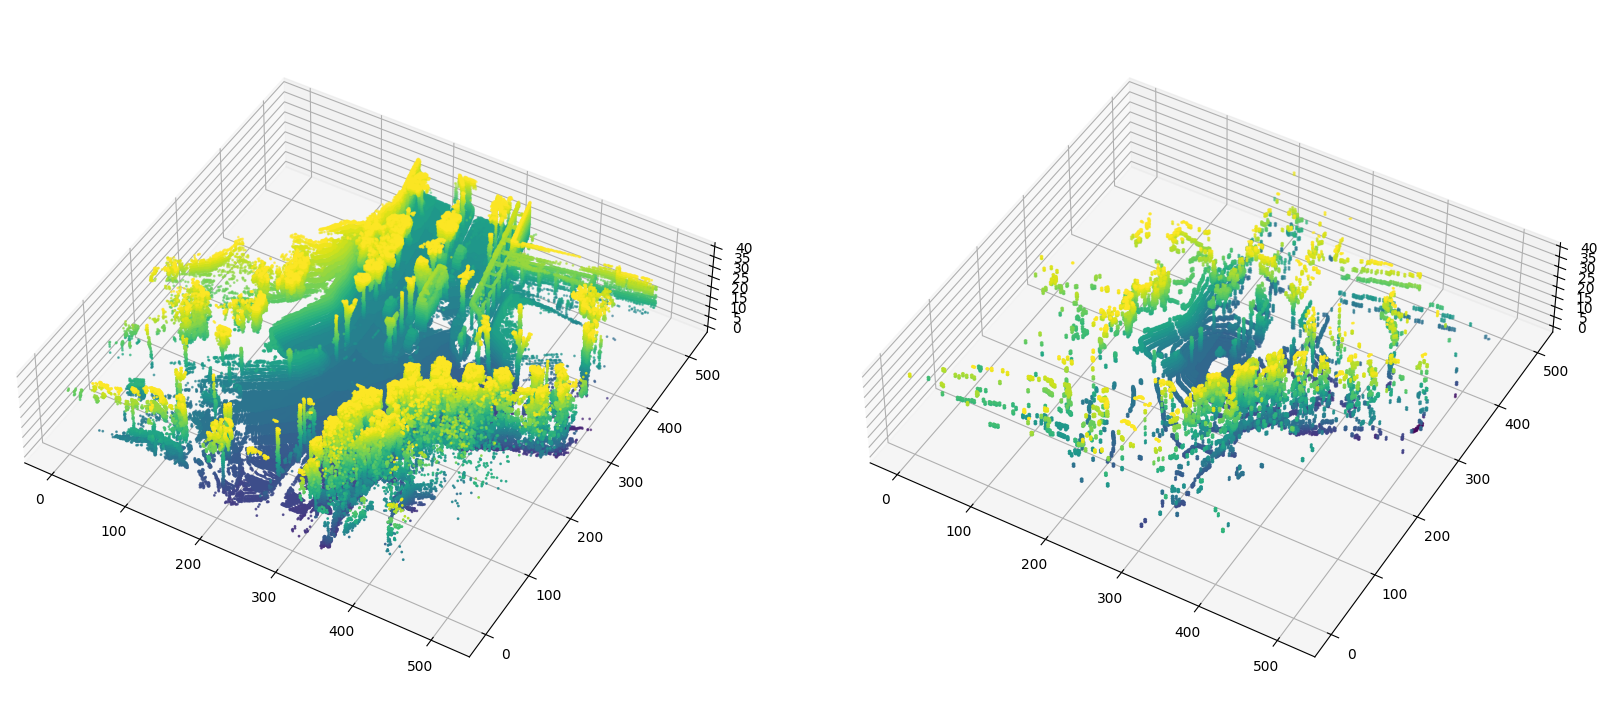

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(i, j, k, c=k, cmap='viridis', s=1)
ax.set_box_aspect((1, 1, 1/4))
ax.view_init(azim=-60, elev=45)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(hi, hj, hk, c=hk, cmap='viridis', s=1)
ax.set_box_aspect((1, 1, 1/4))
ax.view_init(azim=-60, elev=45)

In [15]:
voxel2.shape

torch.Size([1, 256, 256, 32])

In [ ]:
len(nusc)

In [9]:
import tensorrt as trt

ImportError: /home/zc2309/mambaforge/lib/python3.11/site-packages/torch_tensorrt/lib/libtorchtrt.so: undefined symbol: _ZNK3c106SymInt13toSymNodeImplEv

: 

In [4]:
import torch_tensorrt
import torch

ImportError: /home/zc2309/mambaforge/lib/python3.11/site-packages/torch_tensorrt/lib/libtorchtrt.so: undefined symbol: _ZNK3c106SymInt13toSymNodeImplEv

In [ ]:
nusc.sample
sample_data = {d["token"]: d for d in nusc.sample_data}
calibrated = {d["token"]: d for d in nusc.calibrated_sensor}
panoptic = nusc.panoptic

In [ ]:
nusc.get_sample_data(nusc.sample[0]['data'])

In [ ]:
nusc.sample
sample_data = {d["token"]: d for d in nusc.sample_data}
calibrated = {d["token"]: d for d in nusc.calibrated_sensor}
metadata = []
for index, sa in enumerate(nusc.sample):
    meta = {}
    meta.update(nusc.sample[index])
    meta["panoptic"] = panoptic[index]
    for name, token in sa['data'].items():
        meta[name] = (
            sample_data[token].update(calibrated[sample_data[token]["calibrated_sensor_token"]])
        )
    metadata.append(meta)

In [ ]:
import pandas as pd

def _build_metadata(self, nusc: NuScenes) -> pd.DataFrame:
    sample = nusc.sample
    sample_data = {d["token"]: d for d in nusc.sample_data}
    calibrated = {d["token"]: d for d in nusc.calibrated_sensor}
    panoptic = nusc.panoptic
    metadata = []
    for index, sa in enumerate(sample):
        meta = {}
        meta.update(sample[index])
        sample_token = sample[index]["token"]
        sample = sample_data[sample_token]
        meta["panoptic"] = panoptic[index]
        for name, token in sa.items():
            meta[name] = (
                sample_data[token]
                + calibrated[sample_data[token]["calibrated_sensor_token"]]
            )
        metadata.append(meta)
    return pd.DataFrame.from_records(metadata)

In [ ]:
dataset[0].lidar_top

In [ ]:
from transformers import AutoModel

In [ ]:
from occupancy.models import create_model


model = create_model('resnet18')

In [ ]:
create_model('resnet18')

In [ ]:
dataset[0]

In [ ]:
from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-trainval', dataroot=root, verbose=True)

In [ ]:
CAM_FRONT = '020d7b4f858147558106c504f7f31bef'

In [ ]:
nusc.sample[0]

In [ ]:
nusc.get_sample_data('020d7b4f858147558106c504f7f31bef')

In [ ]:
nusc.get_sample_data(CAM_FRONT)

In [ ]:
camera_data = [d for d in nusc.sample_data if d['channel'] == 'CAM_FRONT']

In [ ]:
nusc.get_sample_data(camera_data[0]['token'])

In [ ]:
calibrated_camera = {d['token']: d for d in nusc.calibrated_sensor if len(d['camera_intrinsic']) > 0}
sample_data = {d['token']: d for d in nusc.sample_data}

In [ ]:
sample_data = {d['token']: d for d in nusc.sample_data}

In [ ]:
camera = sample_data[CAM_FRONT]
cali = calibrated_camera[camera['calibrated_sensor_token']]

In [ ]:
cali

In [ ]:
calibrated_camera

In [ ]:
nusc.sensor[0]

In [ ]:
nusc.get_sample_data(CAM_FRONT)


In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import numpy as np
import torch

width = 40
i, j, k = torch.meshgrid(torch.linspace(-1, 1, width), torch.linspace(-1, 1, width), torch.linspace(-1, 1, width), indexing='ij')
h = torch.ones_like(i)
voxel_grid = torch.stack((i, j, k, h), dim=-1).unsqueeze(0)
images = torch.zeros(1, 6, 1, 10, 10)
images[0, 0] = 1#torch.cat([torch.arange(5) + 1,  reversed(torch.arange(5) + 1)])
images[0, 1] = 2
images[0, 2] = 3
images[0, 3] = 4
images[0, 4] = 5
images[0, 5] = 6

f = 2
c2i = torch.tensor([[f, 0, 0, 0], [0, f, 0, 0], [0, 0, 1, 0]]).float()


c2i[:3, :3] = c2i[:3, :3] @ Rotation.from_euler('z', -90, degrees=True).as_matrix()
r = Rotation.from_euler('y', 60, degrees=True).as_matrix()
R = np.eye(4)
R[:3, :3] = r
print(R)
R =torch.from_numpy(R).float()

M1 = torch.eye(4)
M2 = M1 @ R 
M3 = M2 @ R
M4 = M3 @ R
M5 = M4 @ R
M6 = M5 @ R

M1 = c2i @ M1
M2 = c2i @ M2
M3 = c2i @ M3
M4 = c2i @ M4
M5 = c2i @ M5
M6 = c2i @ M6

M = torch.stack((M1, M2, M3, M4, M5, M6), dim=0)


bev = lift_splat_shoot(images, voxel_grid, M)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

x, y, z=  torch.where(bev[0, 0] > 0)
c = bev[0, 0, x, y, z]

x = (x - width/2) / width
y = (y - width/2) / width
z = (z - width/2) / width
ax.scatter(x, y, z, c=c, alpha=0.1, cmap='tab10', marker='.')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=90, azim=0)

In [ ]:

from occupancy.datasets.nuscenes import NuscenesDataset


root = '/mnt/f/datasets/nuscenes/'
dataset = NuscenesDataset(root, '.cache/nuscenes')
data = dataset[0]
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
depthmaps = glob.glob("Marigold/output/nuscenes/depth_npy/*.npy")
depthmaps = sorted(depthmaps)

In [ ]:
front_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_FRONT__*")[0])
front_right_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_FRONT_RIGHT__*")[0])
back_right_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_BACK_RIGHT__*")[0])
back_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_BACK__*")[0])
back_left_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_BACK_LEFT__*")[0])
front_left_depth = np.load(glob.glob("Marigold/output/nuscenes/depth_npy/*__CAM_FRONT_LEFT__*")[0])

depthmaps = [front_depth, front_right_depth, back_right_depth, back_depth, back_left_depth, front_left_depth]
depthmaps = np.stack(depthmaps, axis=0)
depthmaps = torch.from_numpy(depthmaps).float()

In [ ]:
import torch
intrinsics = [
    data.cam_front.intrinsic,
    data.cam_front_right.intrinsic,
    data.cam_back_right.intrinsic,
    data.cam_back.intrinsic,
    data.cam_back_left.intrinsic,
    data.cam_front_left.intrinsic,
]

intrinsics = torch.cat(intrinsics, dim=0)
extrinsics = [
    data.cam_front.extrinsic,
    data.cam_front_right.extrinsic,
    data.cam_back_right.extrinsic,
    data.cam_back.extrinsic,
    data.cam_back_left.extrinsic,
    data.cam_front_left.extrinsic,
]
extrinsics = torch.cat(extrinsics, dim=0)

In [ ]:
import torch
from torch import Tensor
from pyquaternion import Quaternion
def depthmap_to_world_coordinates(depthmap: Tensor, intrinsic: Tensor, extrinsic: Tensor) -> Tensor:
    """Project points from image coordinates to world coordinates.

    Args:
        depthmap: A tensor of shape (B, H, W) containing the depthmap.
        intrinsic: A tensor of shape (B, 3, 3) containing the intrinsic matrix.

    Returns:
        A tensor of shape (B, H, W, 3) containing the world coordinates.
    """

    #depthmap = depthmap.transpose(-1, -2) # numpy convention

    batch_size, height, width = depthmap.shape
    device = depthmap.device
    dtype = depthmap.dtype

    
    # Create the pixel grid
    i, j = torch.meshgrid(
        torch.arange(height, device=device, dtype=dtype),
        torch.arange(width, device=device, dtype=dtype),
        indexing='ij', # numpy convention
    )

    # Create the pixel coordinates
    depthmap = depthmap.reshape(batch_size, 1, -1)
    i = i.reshape(1, -1).expand_as(depthmap)
    j = j.reshape(1, -1).expand_as(depthmap)
    f = intrinsic[:, 0, 0].view(batch_size, 1, 1)
    pixel_coordinates = torch.cat((i, j, torch.ones_like(i)), dim=1) 

    # Convert the pixel coordinates to camera coordinates
    K_inv = torch.inverse(intrinsic)
    camera_coordinates = torch.matmul(K_inv, pixel_coordinates)

    camera_coordinates = camera_coordinates[:, [1, 2, 0],]
    
    rotation = extrinsic[:, :3, :3]
    translation = extrinsic[:, :3, 3].type_as(camera_coordinates)

    #rotation = torch.as_tensor(rotation)[:, :3, :3].type_as(camera_coordinates)
    world_coordinates = torch.matmul(rotation.transpose(-1, -2), camera_coordinates - translation.view(batch_size, 3, 1))

    # Since the camera is at the origin, the camera coordinates are the world coordinates
    world_coordinates = world_coordinates.view(batch_size, 3, height, width)

    return world_coordinates.permute(0, 2, 3, 1)

In [ ]:
points = depthmap_to_world_coordinates(depthmaps.double(), intrinsics.double(), extrinsics.double())
points = points.reshape(-1, 3)

In [ ]:
import pyvista as pv

point_cloud = pv.PolyData(points.numpy())
point_cloud["depth"] = depthmaps.reshape(-1).numpy()
point_cloud.plot()

In [ ]:
def log_prob(mean: Tensor, logvar: Tensor, weight: Tensor, points: Tensor):
    """Compute the probability of each point belonging to the gaussian mixture.

    Args:
        mean: A tensor of shape (B, N, 3) containing the mean of the Gaussian.
        logvar: A tensor of shape (B, N, 3) containing the log-variance of the Gaussian.
        weight: A tensor of shape (B, N) containing the weight of the Gaussian.
        points: A tensor of shape (B, M, 3) containing the points.

    Returns:
        A tensor of shape (B, N) containing the probability of each point belonging to the gaussian mixture.
    """

    batch_size, num_gaussians, _ = mean.shape
    _, num_points, _ = points.shape
    # Compute the probability of each point belonging to the gaussian mixture
    # https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function
    #
    # We use the log-sum-exp trick to avoid numerical underflow:
    # https://en.wikipedia.org/wiki/LogSumExp

    # Compute the log-probability of each point belonging to each gaussian
    # supports its diagonal gaussian distribution
    logvar = logvar.view(batch_size, num_gaussians, 1, 3)
    log_prob = -0.5 * (logvar + (points.view(batch_size, 1, num_points, 3) - mean.view(batch_size, num_gaussians, 1, 3)) ** 2 / logvar.exp())
    log_prob = log_prob.sum(dim=-1) # sum over the dimensions

    # Compute the log-probability of each point belonging to the gaussian mixture
    # supports its diagonal gaussian distribution
    log_weight = weight.log()
    log_prob = log_prob + log_weight.view(batch_size, num_gaussians, 1)
    log_prob = torch.logsumexp(log_prob, dim=1) # sum over the gaussians

    return log_prob
    

In [ ]:
from typing import Tuple


def polar_to_cartesian(r: Tensor, theta: Tensor, phi: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    x = r * torch.sin(phi) * torch.cos(theta)
    y = r * torch.sin(phi) * torch.sin(theta)
    z = r * torch.cos(phi)
    return x, y, z

def cartesian_to_polar(x: Tensor, y: Tensor, z: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    r = torch.sqrt(x**2 + y**2 + z**2)
    theta = torch.atan2(y, x)
    phi = torch.acos(z / r)
    return r, theta, phi



In [ ]:
import torch
from torch import Tensor, nn

def 


In [ ]:
import onnx
onnx_model = onnx.load("/home/zc2309/workspace/occupancy/sdxl-turbo-tensorrt/vae.opt/model.onnx")
onnx.checker.check_model(onnx_model)
onnx_model_path = "/home/zc2309/workspace/occupancy/sdxl-turbo-tensorrt/vae.opt/model.onnx"

In [ ]:
torch.onnx.dynamo_export()

In [ ]:
from diffusers import OnnxRuntimeModel, AutoencoderKL
onnx_model_path = "/home/zc2309/workspace/occupancy/sdxl-turbo-tensorrt/vae.opt/model.onnx"

In [ ]:
OnnxRuntimeModel.from_pretrained(onnx_model_path)

In [ ]:
onnx_model.ListFields()

In [ ]:
import onnxruntime

session = onnxruntime.InferenceSession(
        onnx_model_path,
        providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider'])

io_binding = session.io_binding()
# OnnxRuntime will copy the data over to the CUDA device if 'input' is consumed by nodes on the CUDA device
io_binding.bind_input('input')
io_binding.bind_output('output')
session.run_with_iobinding(io_binding)
Y = io_binding.copy_outputs_to_cpu()[0]

In [ ]:
from torch import export
export.load("/home/zc2309/workspace/occupancy/sdxl-turbo-tensorrt/vae.opt/model.onnx")

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

In [ ]:
model_config = 'config/diffusion_image2voxel.yml'
from occupancy.pipelines.diffusion_image2voxel import DiffusionImage2VoxelPipelineConfig, to_model_input, DiffusionMultiViewImageToVoxelPipeline
import torch    
model_config = DiffusionImage2VoxelPipelineConfig.from_yaml(model_config)
model = DiffusionMultiViewImageToVoxelPipeline(model_config)
model.load_state_dict(torch.load('models/diffuser.pt', mmap=True), strict=False)
model.voxel_autoencoderkl.load_state_dict(torch.load('models/autoencoderkl.pt', mmap=True), strict=False)

In [ ]:
torch.jit.script(model.image_feature_encoder)

In [ ]:
torc

scripted_model = torch.jit.script(model.voxel_autoencoderkl.encoder)
scripted_model.state_dict()

In [ ]:
model.voxel_autoencoderkl.encoder.load_state_dict(scripted_model.state_dict())

In [ ]:
torch.export.

In [ ]:
scripted_model

In [ ]:
model_config = 'config/diffusion_image2voxel.yml'
from occupancy.pipelines.spin import DiffusionImage2VoxelPipelineConfig, to_model_input, DiffusionMultiViewImageToVoxelPipeline
import torch    
model_config = DiffusionImage2VoxelPipelineConfig.from_yaml(model_config)
model = DiffusionMultiViewImageToVoxelPipeline(model_config)
model.load_state_dict(torch.load('models/diffuser.pt', mmap=True), strict=False)
model.voxel_autoencoderkl.load_state_dict(torch.load('models/autoencoderkl.pt', mmap=True), strict=False)
model.to('cuda')
model.to(torch.bfloat16)

from occupancy.datasets.nuscenes import NuscenesDataset


root = '/mnt/f/datasets/nuscenes/'
dataset = NuscenesDataset(root)

In [ ]:
batch = to_model_input(dataset[4000], device='cuda', dtype=torch.bfloat16)
ground_truth =batch.voxel

In [ ]:
from diffusers import DPMSolverSinglestepScheduler
model.scheduler = DPMSolverSinglestepScheduler.from_config(model.scheduler.config)

In [ ]:
model.scheduler.timesteps == torch.tensor(999)

In [ ]:
output = model.generate(batch, num_inference_steps=50, guidance_scale=2)
batch.voxel = output[-1].prediction
output[-1].ground_truth = ground_truth
output[-1].plot()

In [ ]:
output[-1].plot()


In [ ]:
import torch
torch._dynamo.list_backends()

In [ ]:
#import torch_tensorrt as trt
import torch
from torch import nn
from diffusers import AutoencoderKL
def trace_and_compile(mod: nn.Module, inputs: torch.Tensor) -> nn.Module:
    mod.eval()
    mod = torch.jit.trace(mod, inputs)
    mod = torch.compile(mod, fullgraph=True, dynamic=False, backend='onnxrt')
    return mod
vae = AutoencoderKL.from_pretrained('stabilityai/sdxl-vae', torch_dtype=torch.bfloat16, device='cuda', torchscript=True)
vae.to(torch.bfloat16)
vae.to('cuda')
vae.encoder = trace_and_compile(vae.encoder, torch.rand(1, 3, 256, 256).cuda().bfloat16())
vae.decoder = trace_and_compile(vae.decoder, torch.rand(1, 4, 32, 32).cuda().bfloat16())

In [ ]:
traced_sdxl_vae_encoder = traced_sdxl_vae_encoder.float()

In [ ]:
inputs = torch.rand(1, 3, 256, 256).cuda()
latents = traced_sdxl_vae_encoder(inputs)

In [ ]:
latents.shape

In [ ]:
from torch import fx

graph_vae_encoder = fx.symbolic_trace(vae.encoder)

In [ ]:
import torch

In [ ]:
torch.rand(10, 1) == torch.rand(4)

In [ ]:
import torch_tensorrt as trt
import torch
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained('stabilityai/sdxl-vae', torch_dtype=torch.bfloat16, device='cuda', torchscript=True)
traced_encoder = torch
example_tensor = torch.rand(1, 3, 224, 224).to('cuda').bfloat16()
trt_ts_module = trt.compile(traced_encoder,
    # If the inputs to the module are plain Tensors, specify them via the `inputs` argument:
    inputs = [example_tensor, # Provide example tensor for input shape or...
        trt.Input( # Specify input object with shape and dtype
            min_shape=[1, 3, 224, 224],
            opt_shape=[1, 3, 512, 512],
            max_shape=[1, 3, 1024, 1024],
            # For static size shape=[1, 3, 224, 224]
            dtype=torch.int8) # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    ],

    # For inputs containing tuples or lists of tensors, use the `input_signature` argument:
    # Below, we have an input consisting of a Tuple of two Tensors (Tuple[Tensor, Tensor])
    # input_signature = ( (torch_tensorrt.Input(shape=[1, 3, 224, 224], dtype=torch.half),
    #                      torch_tensorrt.Input(shape=[1, 3, 224, 224], dtype=torch.half)), ),

    enabled_precisions = {torch.half}, # Run with FP16
)

result = trt_ts_module(example_tensor) # run inference
torch.jit.save(trt_ts_module, "trt_torchscript_module.ts") # save the TRT embedded Torchscript

In [ ]:
import os
from occupancy.pipelines.diffusion_image2voxel import AutoEncoderKL3d
import torch

model = AutoEncoderKL3d()

In [ ]:
torch.onnx.dynamo_export()

In [ ]:
x = torch.randn(1, 16, 8, 8, 8).float().cuda()
t = torch.randint(0, 1000, (1, 1)).float().cuda()
c = torch.randn(1, 512, 1024).float().cuda()
y = model(x, c, t)

In [ ]:
total_params = 0
for param in model.parameters():
    total_params += param.numel()
print(total_params)

In [ ]:
def to_human_readable(num):
    for unit in ['','K','M','B','T','P','E','Z']:
        if abs(num) < 1000.0:
            return f"{num:3.1f}{unit}"
        num /= 1000.0
    return f"{num:.1f}Y"
to_human_readable(total_params)